In [2]:
# Just so that you don't have to restart the notebook with every change.
%load_ext autoreload
%autoreload 2 

In [3]:
import os
from functools import partial

import cv2
from PIL import Image

from collections import deque, Counter

import matplotlib.pyplot as plt
import numpy as np
import torch
from captum.attr import DeepLift, IntegratedGradients, NoiseTunnel, Occlusion, Saliency
from captum.attr import visualization as viz
from common import utils
from ultralytics import YOLO
from transformers import AutoImageProcessor

# Useful constants
CURRENT_DIR = os.getcwd()
IMAGES_DIR = os.path.join(CURRENT_DIR, "images")
VIDEOS_DIR = os.path.join(CURRENT_DIR, "videos")
CHORD_CLASSIFIER_MODEL_DIR = os.path.join(CURRENT_DIR, "chord-classifier-model")
FRETBOARD_RECOGNIZER_MODEL_DIR = os.path.join(CURRENT_DIR, "fretboard-recognizer-model")

chord_clf_model_path = utils.find_files(CHORD_CLASSIFIER_MODEL_DIR, [".safetensors", ".pt"])
chord_clf_config_path = utils.find_files(CHORD_CLASSIFIER_MODEL_DIR, [".json"])
fretboard_rec_model_path = utils.find_files(FRETBOARD_RECOGNIZER_MODEL_DIR, [".safetensors", ".pt"])
fretboard_rec_config_path = utils.find_files(FRETBOARD_RECOGNIZER_MODEL_DIR, [".json"])

utils.ensure_files_exist(
    chord_clf_model_path,
    fretboard_rec_model_path,
    chord_clf_config_path,
    fretboard_rec_config_path,
    names=[
        "Chord Classifier model",
        "Fretboard Recognizer model",
        "Chord Classifier config",
        "Fretboard Recognizer config",
    ],
)

/home/dhimitriosduka/miniconda3/envs/hlcv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Chord Classifier model found at /home/dhimitriosduka/Documents/UdS/SoSe 2024/High-Level Computer Vision/Assignments/hlcv/Project/src/live/chord-classifier-model/model.safetensors
Fretboard Recognizer model found at /home/dhimitriosduka/Documents/UdS/SoSe 2024/High-Level Computer Vision/Assignments/hlcv/Project/src/live/fretboard-recognizer-model/yolov9c_trained_with_head.pt
Chord Classifier config found at /home/dhimitriosduka/Documents/UdS/SoSe 2024/High-Level Computer Vision/Assignments/hlcv/Project/src/live/chord-classifier-model/config.json
Fretboard Recognizer config not found


In [4]:
# Load Chord Classifier model
chord_clf_model = utils.load_model(chord_clf_model_path, config_path=chord_clf_config_path)

# Load Fretboard Recognizer model
fretboard_rec_model = utils.load_model(fretboard_rec_model_path, config_path=fretboard_rec_config_path, custom_class=YOLO)

print("Models loaded successfully.")

Models loaded successfully.


In [11]:
def process_video(
        video_path,
        chord_clf_model=None, 
        feature_extractor=None,
        fretboard_rec_model=None
):
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Get video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    print(f"Video FPS: {fps}")

    recent_classifications = deque(maxlen=fps)
    
    current_frame = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        current_frame += 1

        # Convert BGR to RGB
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Convert to PIL Image
        pil_image = Image.fromarray(rgb_frame)

        # Perform inference on the fretboard recognizer model
        results = fretboard_rec_model.predict(pil_image)[0].boxes
        indices = (results.cls == 80).nonzero(as_tuple=True)[0]

        if len(indices) > 0:
            # Get the bounding box with the highest confidence
            max_conf_index = results.conf[indices].argmax()
            result = results.data[indices[max_conf_index]]

            # Increase bounding box size by 15%
            x1, y1, x2, y2 = result[:4]
            width = x2 - x1
            height = y2 - y1
            increase_x = width * 0.90 / 2
            increase_y = height * 0.90 / 2

            new_x1 = max(0, x1 - increase_x)
            new_y1 = max(0, y1 - increase_y)
            new_x2 = min(pil_image.width, x2 + increase_x)
            new_y2 = min(pil_image.height, y2 + increase_y)

            # Crop the fretboard with increased bounding box
            pil_image = pil_image.crop(np.array([new_x1, new_y1, new_x2, new_y2]))

        # Optional: Display the cropped image
        plt.imshow(pil_image)
        plt.show()

        # Preprocess the image
        inputs = feature_extractor(images=pil_image, return_tensors="pt")

        # Perform inference
        with torch.no_grad():
            outputs = chord_clf_model(**inputs)

        # Get the predicted class
        predicted_class_idx = outputs.logits.argmax(-1).item()
        predicted_class = chord_clf_model.config.id2label[predicted_class_idx]

        # Add the prediction to recent classifications
        recent_classifications.append(predicted_class)

        # If we have collected enough frames, determine the most common classification
        if len(recent_classifications) == fps:
            print(recent_classifications)
            most_common_class = Counter(recent_classifications).most_common(1)[0][0]
            print(f"Frame {current_frame}: Most common classification in last {fps} frames: {most_common_class}")
            recent_classifications.clear()
        
        # Optional: Print progress
        if current_frame % 100 == 0:
            print(f"Processed {current_frame}/{current_frame} frames")
    
    cap.release()

Video FPS: 25

0: 288x640 1 person, 1 snowboard, 2 fretboards, 301.0ms
Speed: 21.8ms preprocess, 301.0ms inference, 0.8ms postprocess per image at shape (1, 3, 288, 640)


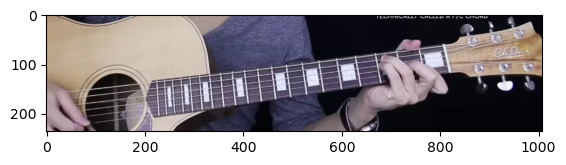


0: 288x640 1 person, 2 fretboards, 325.6ms
Speed: 2.4ms preprocess, 325.6ms inference, 0.6ms postprocess per image at shape (1, 3, 288, 640)


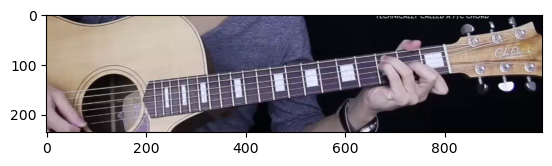


0: 288x640 1 person, 1 snowboard, 2 fretboards, 361.0ms
Speed: 1.8ms preprocess, 361.0ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 640)


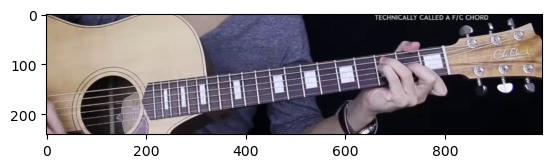


0: 288x640 1 person, 1 snowboard, 3 fretboards, 319.1ms
Speed: 1.6ms preprocess, 319.1ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 640)


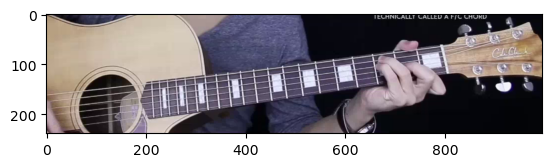


0: 288x640 1 person, 2 fretboards, 285.8ms
Speed: 1.2ms preprocess, 285.8ms inference, 0.6ms postprocess per image at shape (1, 3, 288, 640)


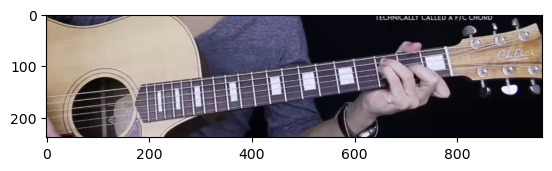


0: 288x640 1 person, 3 fretboards, 281.9ms
Speed: 1.3ms preprocess, 281.9ms inference, 0.6ms postprocess per image at shape (1, 3, 288, 640)


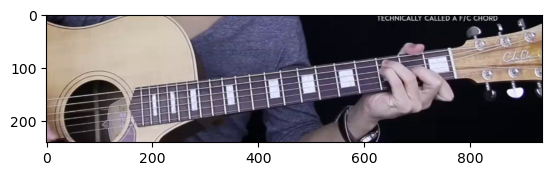


0: 288x640 1 person, 2 fretboards, 272.6ms
Speed: 1.4ms preprocess, 272.6ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 640)


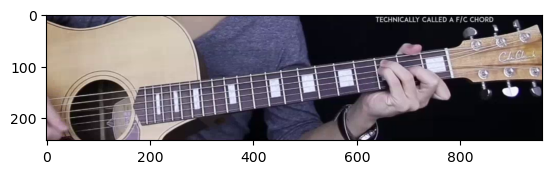


0: 288x640 1 person, 3 fretboards, 257.2ms
Speed: 1.4ms preprocess, 257.2ms inference, 0.6ms postprocess per image at shape (1, 3, 288, 640)


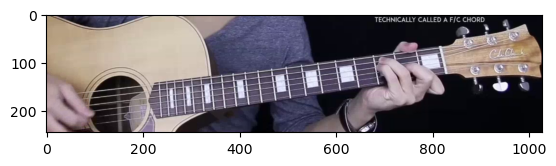


0: 288x640 1 person, 3 fretboards, 324.6ms
Speed: 1.6ms preprocess, 324.6ms inference, 0.6ms postprocess per image at shape (1, 3, 288, 640)


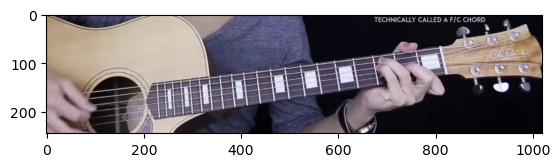


0: 288x640 1 person, 3 fretboards, 349.7ms
Speed: 1.7ms preprocess, 349.7ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 640)


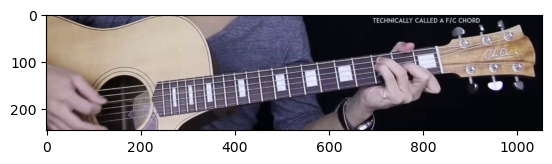


0: 288x640 1 person, 3 fretboards, 360.4ms
Speed: 1.4ms preprocess, 360.4ms inference, 0.9ms postprocess per image at shape (1, 3, 288, 640)


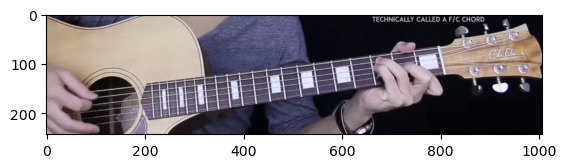


0: 288x640 1 person, 3 fretboards, 271.2ms
Speed: 2.4ms preprocess, 271.2ms inference, 0.6ms postprocess per image at shape (1, 3, 288, 640)


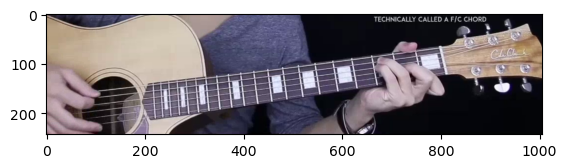


0: 288x640 1 person, 3 fretboards, 268.3ms
Speed: 1.5ms preprocess, 268.3ms inference, 0.6ms postprocess per image at shape (1, 3, 288, 640)


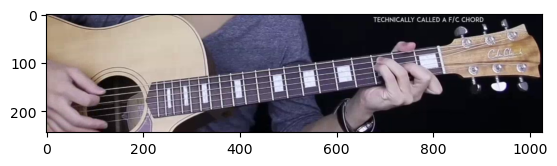


0: 288x640 1 person, 3 fretboards, 268.5ms
Speed: 1.4ms preprocess, 268.5ms inference, 0.6ms postprocess per image at shape (1, 3, 288, 640)


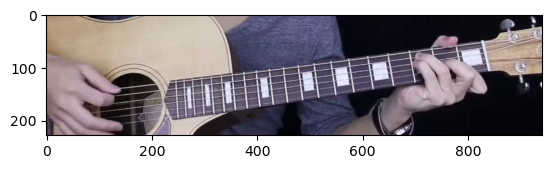


0: 288x640 1 person, 3 fretboards, 348.2ms
Speed: 1.4ms preprocess, 348.2ms inference, 0.6ms postprocess per image at shape (1, 3, 288, 640)


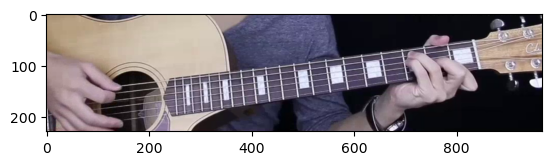


0: 288x640 1 person, 3 fretboards, 290.6ms
Speed: 1.6ms preprocess, 290.6ms inference, 0.6ms postprocess per image at shape (1, 3, 288, 640)


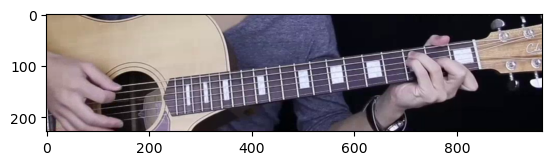


0: 288x640 1 person, 3 fretboards, 299.4ms
Speed: 1.4ms preprocess, 299.4ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)


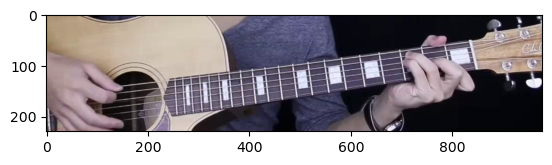


0: 288x640 1 person, 3 fretboards, 301.1ms
Speed: 1.5ms preprocess, 301.1ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 640)


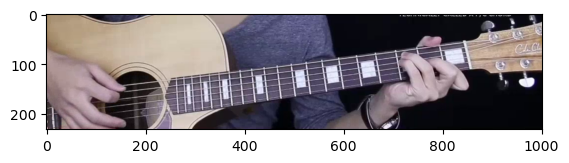


0: 288x640 1 person, 3 fretboards, 378.4ms
Speed: 1.7ms preprocess, 378.4ms inference, 0.6ms postprocess per image at shape (1, 3, 288, 640)


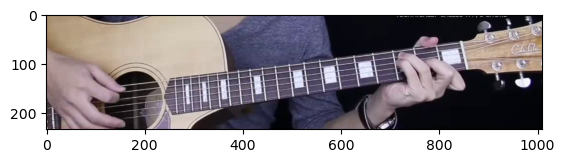


0: 288x640 1 person, 3 fretboards, 381.1ms
Speed: 1.5ms preprocess, 381.1ms inference, 0.6ms postprocess per image at shape (1, 3, 288, 640)


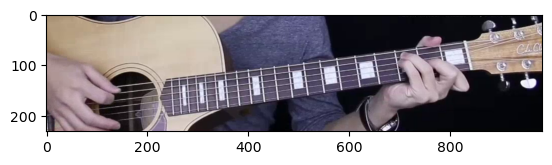


0: 288x640 1 person, 3 fretboards, 332.5ms
Speed: 1.7ms preprocess, 332.5ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 640)


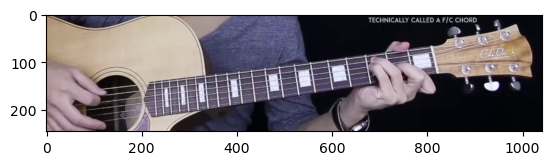


0: 288x640 1 person, 3 fretboards, 286.7ms
Speed: 1.3ms preprocess, 286.7ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 640)


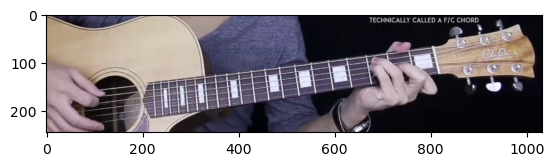


0: 288x640 1 person, 3 fretboards, 326.6ms
Speed: 1.3ms preprocess, 326.6ms inference, 0.8ms postprocess per image at shape (1, 3, 288, 640)


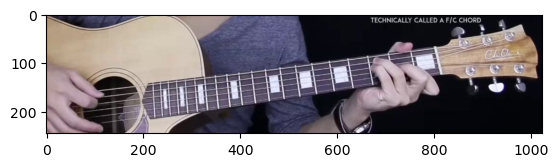


0: 288x640 1 person, 3 fretboards, 329.4ms
Speed: 1.7ms preprocess, 329.4ms inference, 0.6ms postprocess per image at shape (1, 3, 288, 640)


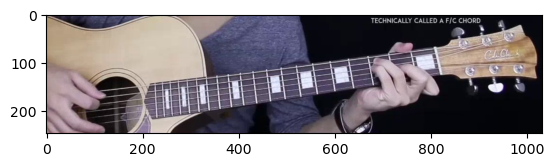


0: 288x640 1 person, 3 fretboards, 324.2ms
Speed: 1.3ms preprocess, 324.2ms inference, 0.9ms postprocess per image at shape (1, 3, 288, 640)


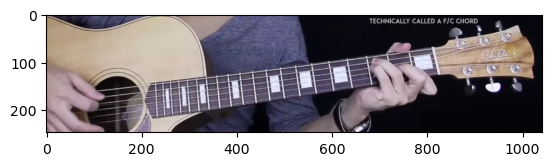

deque(['B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B'], maxlen=25)
Frame 25: Most common classification in last 25 frames: B

0: 288x640 1 person, 1 snowboard, 3 fretboards, 298.8ms
Speed: 1.3ms preprocess, 298.8ms inference, 0.6ms postprocess per image at shape (1, 3, 288, 640)


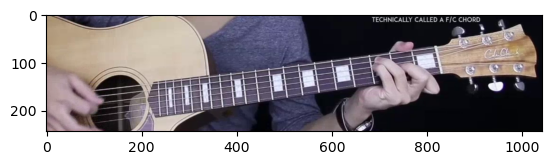


0: 288x640 1 person, 1 snowboard, 3 fretboards, 323.4ms
Speed: 1.8ms preprocess, 323.4ms inference, 0.6ms postprocess per image at shape (1, 3, 288, 640)


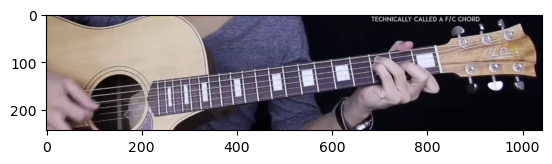


0: 288x640 1 person, 1 snowboard, 3 fretboards, 350.5ms
Speed: 1.3ms preprocess, 350.5ms inference, 0.8ms postprocess per image at shape (1, 3, 288, 640)


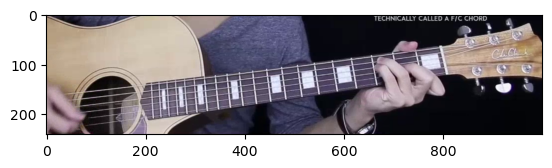


0: 288x640 1 person, 1 snowboard, 3 fretboards, 411.7ms
Speed: 2.1ms preprocess, 411.7ms inference, 0.8ms postprocess per image at shape (1, 3, 288, 640)


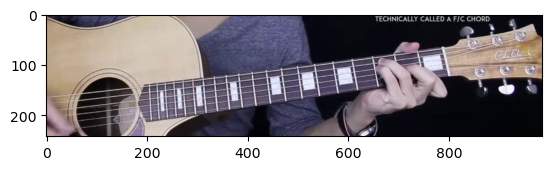


0: 288x640 1 person, 2 snowboards, 1 surfboard, 4 fretboards, 416.7ms
Speed: 1.4ms preprocess, 416.7ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 640)


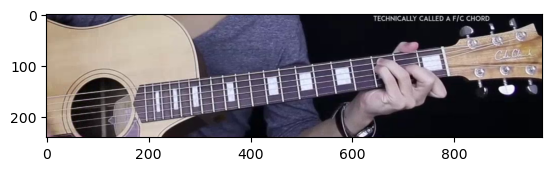


0: 288x640 1 person, 2 snowboards, 3 fretboards, 370.1ms
Speed: 1.8ms preprocess, 370.1ms inference, 0.6ms postprocess per image at shape (1, 3, 288, 640)


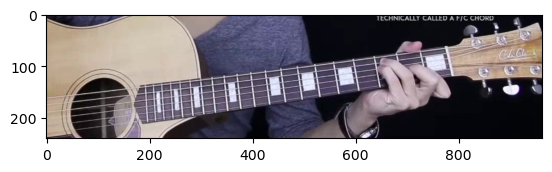


0: 288x640 1 person, 1 snowboard, 1 surfboard, 3 fretboards, 333.8ms
Speed: 2.4ms preprocess, 333.8ms inference, 0.6ms postprocess per image at shape (1, 3, 288, 640)


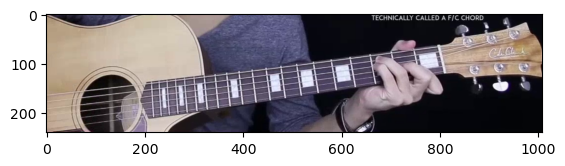

KeyboardInterrupt: 

In [12]:
video_path = "/home/dhimitriosduka/Videos/Screencasts/Screencast from 2024-08-25 23-34-27.mp4"

feature_extractor = AutoImageProcessor.from_pretrained("facebook/dinov2-small")

process_video(
    video_path,
    chord_clf_model=chord_clf_model,
    feature_extractor=feature_extractor,
    fretboard_rec_model=fretboard_rec_model 
)